- Created: [Danny Mitchell](https://www.mrc-cbu.cam.ac.uk/people/Daniel.Mitchell) with thanks to [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/)
- Last updated: July 2025
- Conda environment: This uses the `mri` environment

# Classification in python using scikit-learn

Much of this tutorial is based on, or inspired by, the longer fMRI-pattern-analysis course developed by Lukas Snoek at the University of Amsterdam, which you can find here: https://lukas-snoek.com/NI-edu/index.html 

In these demos, we will start with simulated data; then we will move on to real fMRI data. However, most of the principles apply to any source of data patterns. See Mate's sessions tomorrow for examples applied to EEG/MEG.

# Part I: Simulations

## Getting Ready

To give python the functionality we need, we have to **import** a bunch of packages (See Kshipra's session).
Many of these you will have  seen in previous sessions. The important package for today is Scikit-learn: this is a popular and powerful library for machine learning in Python. It has a very useful website: https://scikit-learn.org/stable

In [1]:
import numpy as np               # Lets python process matrices, like Matlab
np.set_printoptions(precision=3) # Tells numpy to display 3 decimal places

import warnings                 # Allows harmless warnings to be hidden 

import matplotlib.pyplot as plt # Lets python plot graphs like Matlab
import seaborn as sns           # Another popular set of plotting functions
import pandas as pd             # To use "dataframes" (like tables in Matlab)
import os                       # To interact with the operating system, including files and paths (e.g. path.join)
import time                     # To use "time" (like "tic" in Matlab)

import nibabel as nib           # Basic nifti image utilities

import nilearn as nil           # Many useful functions for MRI, including...
from nilearn import image       # to load (load_img), resample (resample_to_img), manipulate (math_img) fMRI data, etc.
from nilearn import datasets    # includes e.g. fetch_atlas_harvard_oxford
from nilearn import masking
from nilearn import maskers     # includes NiftiMasker, NiftiLabelsMasker
from nilearn import plotting    # includes plot_roi, plot_stat_map, view_img_on_surf, etc.
from nilearn import decoding    # includes Searchlight

# scikit-learn is the major library for machine learning in Python:
import sklearn as skl
from sklearn import preprocessing         # includes LabelEncoder, OneHotEncoder, StandardScaler...
from sklearn import decomposition         # includes PCA
from sklearn import model_selection       # includes StratifiedKFold, LeaveOneGroupOut, etc....
from sklearn import linear_model          # includes LogisticRegression, RidgeClassifier...
from sklearn import svm                   # includes SVC, NuSVC & LinearSCV...
from sklearn import discriminant_analysis # includes LinearDiscriminantAnalysis
from sklearn import metrics               # includes accuray, balanced accuracy, roc_auc_score, etc....
from sklearn import pipeline              # includes make_pipeline
from sklearn import inspection            # includes DecisionBoundaryDisplay

# scipy? # provides basic statistic functions, e.g. t-tests, and allows import of Matlab files
# glob?  # to search filenames with wildcards
# copy?  # contains deepcopy (to ACTUALLY copy, rather than making a new pointer to same object)

%matplotlib inline 
# (to show plots in cell)

import bids.layout  # To fetch data from BIDS-compliant datasets

\
First, we'll **set the seed to numpy's random number generator**, to get the same sequence of random values every time:

In [2]:
np.random.seed(3) # (if it's not desireable to set a global seed, a seeded RandomState can be passed to the relevant functions)


## Examples using simulated data, with a true effect

### Define data matrix and labels:

Now, we'll **simulate some data from a single participant**.
Let's define **two conditions**, for eample button presses using two different fingers.
We'll simulate **four runs**, with **three repeats** of each condition per run. We'll assume that each repeat has been separately estimated from a GLM (see Rik's & Dace's sessions), so we would have 4 x 3 x 2 = 24 activation patterns. In an fMRI experiment, these might be whole-brain volumes; in E/MEG these might be activations across electrodes. The values in each pattern could be beta coefficients, contrasts, or t statistics.
For now, **we'll just consider two voxels** from each activation map, to make things easier to visualise.

In [3]:
nruns = 4     # number of runs 
n_per_run = 3 # number of repetitions per run
mu1 = np.array([ 2.0, -0.5]) # mean activation for condition 1 (1st voxel activated; 2nd voxel deactivated)
mu2 = np.array([-0.5,  2.0]) # mean activation for condition 2 (opposite pattern)
voxel_covariance = np.diag([0.0, 3.0])+1 # independent noise per voxel; 2nd voxel is noisier; shared noise is positively correlated
# print("Noise covariance matrix: \n", voxel_covariance )

data_per_run = []   # list of pattern matrices (one per run)
labels_per_run = [] # list of label vectors (one per run)
for r in np.arange(nruns):  # loop over runs
    a1 = np.random.multivariate_normal(mu1, voxel_covariance, size = n_per_run) # activations for condition 1
    a2 = np.random.multivariate_normal(mu2, voxel_covariance, size = n_per_run) # activations for condition 2 (different mean, same noise covarience)
    data_matrix = np.concatenate((a1, a2), axis = 0) # stack condition 1 (n rows of observations) then condition 2 (n more observations)
    # add some extra noise that is similar across conditions and voxels, but whose mean and variance increases across runs:
    data_matrix = data_matrix + np.random.normal( r*10, r, size = (2*n_per_run, 2))
    
    label_vector = n_per_run*["Thumb"] + n_per_run*["Index"] # give each pattern a label that indicates from which condition it was drawn
    
    data_per_run.append(   data_matrix  )  # append this run's data to list
    labels_per_run.append( label_vector ) 
    
print("\nData matrix for first run:\n", data_per_run[0])
print("\nLabel vector for first run:\n", labels_per_run[0])


Data matrix for first run:
 [[ 3.424  2.945]
 [ 0.569  0.142]
 [ 1.55  -0.965]
 [-1.051  1.987]
 [-0.908  2.028]
 [-0.583 -0.822]]

Label vector for first run:
 ['Thumb', 'Thumb', 'Thumb', 'Index', 'Index', 'Index']


\
We now have everything we need for a decoding analysis. However, functions often require data to be represented numerically, so we will also **convert the labels to integers**. This can be done in various ways, but here we'll use the the `LabelEncoder` class from scikit-learn:

In [4]:
lab_enc = skl.preprocessing.LabelEncoder() # this initialises the LabelEncoder object
labels_per_run_int = []
for r in np.arange(nruns):
    labels_per_run_int.append( lab_enc.fit_transform(labels_per_run[r]) )
    
print("Integer labels for all runs:\n", labels_per_run_int)

Integer labels for all runs:
 [array([1, 1, 1, 0, 0, 0]), array([1, 1, 1, 0, 0, 0]), array([1, 1, 1, 0, 0, 0]), array([1, 1, 1, 0, 0, 0])]


\
Notice that we first initialised a `LableEncoder` object, and then called its `.fit_transform` method. Many objects also have `.fit` and `.transform` methods that can be called separately. This procedure is similar for most objects in scikit-learn.

Before doing anything else, let's **plot the data:**

In [5]:
concatenated_runs  = np.concatenate(data_per_run,axis=0)       # concatenate data across runs
concatenated_labels= np.concatenate(labels_per_run_int,axis=0) # concatenate labels across runs

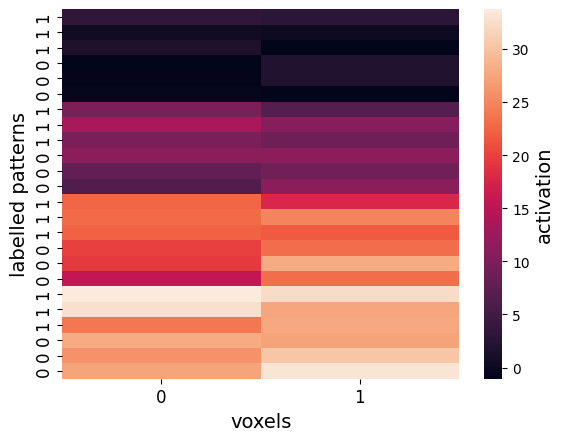

In [6]:
ax = sns.heatmap(concatenated_runs, yticklabels = concatenated_labels);
ax.set_xlabel( "voxels", fontsize = 14)
ax.set_ylabel("labelled patterns", fontsize = 14)
ax.tick_params(axis='x', labelsize = 12)
ax.tick_params(axis='y', labelsize = 12)
ax.collections[0].colorbar.set_label("activation", fontsize = 14)

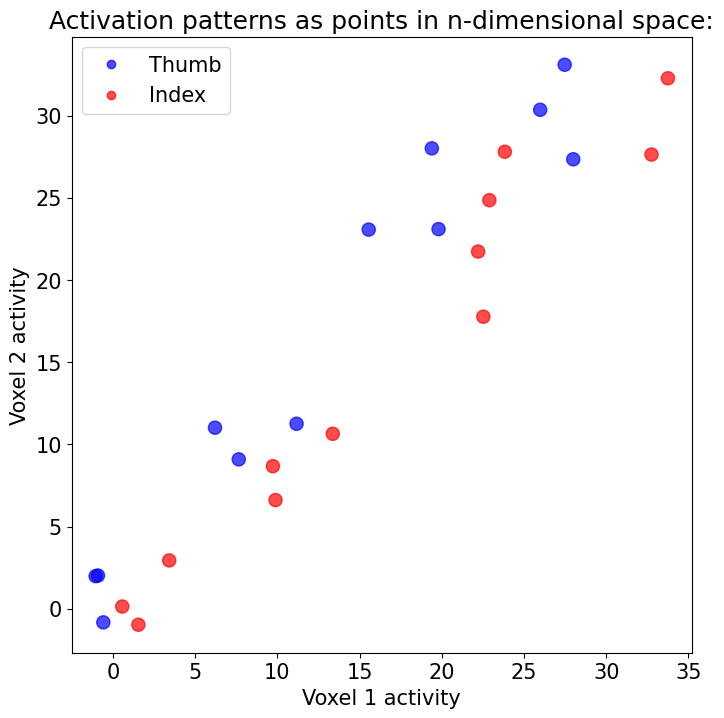

In [7]:
fig = plt.figure(figsize = (8,8));  # create a matplotlib figure
plt.rcParams.update({'font.size': 15});
plt.title('Activation patterns as points in n-dimensional space:');
scatter = plt.scatter(concatenated_runs[:,[0]], concatenated_runs[:,[1]], 
                      s = 90, alpha = 0.7, c = concatenated_labels, cmap = 'bwr');
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels_per_run[0])); # "set" returns unique values
plt.xlabel('Voxel 1 activity');
plt.ylabel('Voxel 2 activity');
plt.axis('equal');

You can imagine that, by drawing a diagonal line y=x, one could separate most of the red dots from most of the blue dots. This would be a "decision boundary" that a classifier needs to learn.


### Initial classification, without cross-validation:

At this stage, it is common to **standardise each feature**, e.g. by rescaling into the range [0 1], or by z-scoring (subtracting the mean and dividing by the standard deviation across samples). For many classifiers, standardizing each feature across all samples should not change the classification accuracy. (Imagine how these transformations change the distribution of the data in the figure above.) However, putting each feature on the scame scale can help parameters to be estimated efficiently, and may be necessary for some models to converge. 

Consider whether it would it be a good or bad idea to rescale features for each class separately? 

Would it be a good or bad idea to rescale features for each run separately?

For now, let's z-score each feature across all samples of all runs. Again, we can do this by initialising a scikit-learn object and calling its `fit_transform` method:

In [8]:
scaler            = skl.preprocessing.StandardScaler()
concatenated_runs = scaler.fit_transform(concatenated_runs)

Let's plot the data again to confirm:

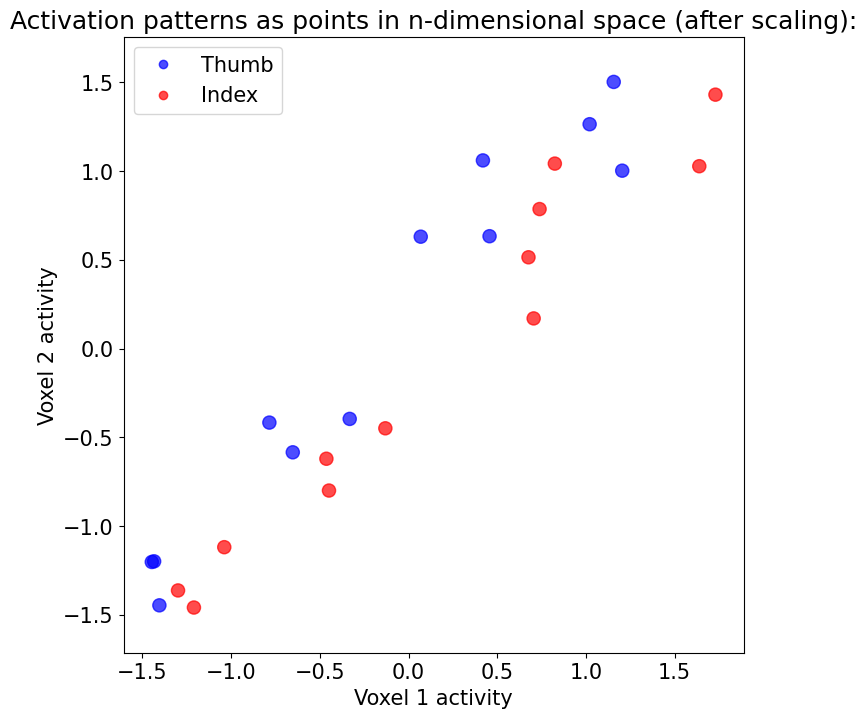

In [9]:
fig=plt.figure(figsize = (8,8));  # create a matplotlib figure
plt.rcParams.update({'font.size': 15});
plt.title('Activation patterns as points in n-dimensional space (after scaling):');
scatter = plt.scatter(concatenated_runs[:,[0]], concatenated_runs[:,[1]], 
                      s = 90, alpha = 0.7, c = concatenated_labels, cmap = 'bwr');
plt.legend(handles=scatter.legend_elements()[0], labels = set(labels_per_run[0])); # "set" returns unique values
plt.xlabel('Voxel 1 activity');
plt.ylabel('Voxel 2 activity');
plt.axis('equal');

\
Now we can proceed to classification. We'll start with a logistic regression classifier, which we'll initialise to a variable called `LR`. (There are lots of different types of classifier, and we'll look at some others later. For some discussion of their pro sand cons, see [this blog](https://medium.com/analytics-vidhya/pros-and-cons-of-popular-supervised-learning-algorithms-d5b3b75d9218).)

Each **classifier needs to be "trained" or "fit" using "training data" and corresponding labels.** This uses the training data to optimise the parameters of the model, to best match the labels to some function (often a linear combination) of the features.

In scikit-learn, this uses the `.fit` method of the classifier, which needs to be given the patterns matrix and labels as inputs. To start with, we'll train the classfier using all the data, concatenated across runs:

In [10]:
LR = skl.linear_model.LogisticRegression(solver = 'lbfgs') # there are more options that could be set here; we won't worry about them
LR.fit(concatenated_runs, concatenated_labels)

LogisticRegression()

The **estimated (fitted) coefficients are now stored in the classifier object**. Notice that for this linear classifier we have one coefficient per feature (voxel):

In [11]:
print("Coefficients:\n", LR.coef_)

Coefficients:
 [[ 1.03  -0.959]]


\
These coefficients define the linear decision boundary, so we can now plot this:

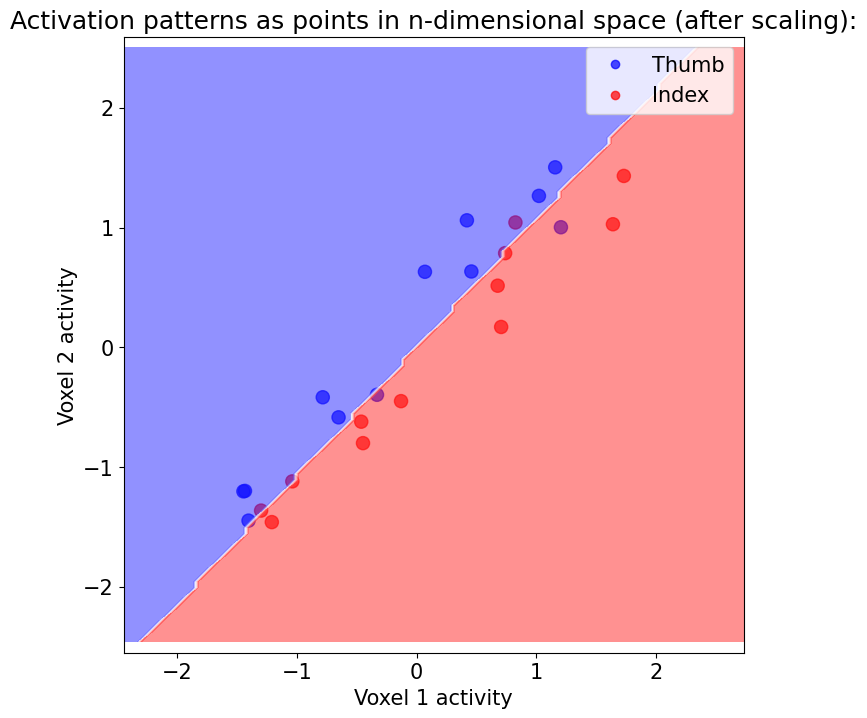

In [12]:
skl.inspection.DecisionBoundaryDisplay.from_estimator(LR, concatenated_runs, 
                                                      alpha = 0.5, ax = fig.axes[0], cmap = 'bwr', response_method = 'predict');
fig

\
The next step is to **"test" the model, by giving it some patterns and "predicting" their labels**. For now, we'll give it the same data we used to train the model. (Some of you may have a question at this point - if so, hold that thought...) 

In [13]:
predicted_labels = LR.predict(concatenated_runs)
print("Predictions for all samples:\n", predicted_labels)

Predictions for all samples:
 [1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0]


\
How accurate are these predictions? We can **"evaluate" the predictions by comparing them with the true values. The quality of the predictions is summarised as a "performance", "score" or "metric"**. If we had continuous predictions (a regression model), we might correlate them with the true values. Here we have categorical predictions (a classification model), which we can compare with the true values in various ways...


### Measures of accuracy

The **simplest score, called "accuracy," is just the proportion of all predictions that are correct**. What is the best possible accuracy? What is the worst possible accuracy? What accuracy would we expect by chance?

Calculating accuracy is easy:

In [14]:
print("Accuracy = ", np.mean(concatenated_labels == predicted_labels))

Accuracy =  0.8333333333333334


\
Scikit-learn also has a function to do this:

In [15]:
accuracy = skl.metrics.accuracy_score(concatenated_labels, predicted_labels)
print("Accuracy = ", accuracy)

Accuracy =  0.8333333333333334


\
Actually scikit-learn has **many metrics to choose from.** The only thing to recommend accuracy as a metric is its simplicity. Otherwise, it is relatively insensitive (because binary guesses discard information about the confidence of a particular prediction) and can be misleading if classes are unbalanced (more about that later).

A metric that incorporates the confidence of each prediction, and can handle unbalanced classes, but is rather complicated, is the "**Area Under the Receiver Operating Characteristic curve**" (AUROC, or just AUC). We can use a function from scikit-learn to calculate this, but instead of vectors of true and predicted labels, it generally needs matrices of true and predicted probabilities per class. (In this binary case, we could give it the vector labels and the probabilities for the class with the largest label, but this syntax doesn't generalise to more than two classes).

Matrices of *true* class probabilities can be constructed from the true labels using scikit-learn's `one-hot encoder` function:


In [16]:
ohe = skl.preprocessing.OneHotEncoder(sparse_output = False)              # we don't want a "sparse" output
true_probabilities = ohe.fit_transform(concatenated_labels.reshape(-1,1)) # the reshape is needed because the function expects a 2D input
print("True probabilities per class, for first 5 patterns:\n", true_probabilities[0:5])

True probabilities per class, for first 5 patterns:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


\
Matrices of predicted class probabilities can be returned by many classifier objects, including logistic regression:

In [17]:
predicted_probabilities = LR.predict_proba(concatenated_runs) # notice we have just swapped the "predict" method for "predict_proba"
print("Predicted probabilities per class, for first 5 patterns:\n", predicted_probabilities[0:5])

Predicted probabilities per class, for first 5 patterns:
 [[0.499 0.501]
 [0.507 0.493]
 [0.461 0.539]
 [0.583 0.417]
 [0.581 0.419]]


\
With these, we can now calculate the AUROC:

In [18]:
AUROC = skl.metrics.roc_auc_score(true_probabilities, predicted_probabilities)
print("AUROC = ", AUROC)
AUROC = skl.metrics.roc_auc_score(concatenated_labels, predicted_probabilities[:,1]) # alternative syntax for binary classifcation
print("AUROC = ", AUROC)

AUROC =  0.9027777777777777
AUROC =  0.9027777777777777


\
Notice that the performance is a bit better than simple accuracy. (Both metrics are bounded between 0 and 1. For AUROC, chance is 0.5. For balanced binary classification, as here, chance accuracy is also 0.5.)

So far, so good. BUT... **these results are biased and cannot be trusted, because we tested the model on the same data that we used for training!** This is like taking an exam after having already seen the correct answers. To emphasise the problem, let's create a **new simulated dataset**, with the same trial structure, but a more realistic number of features/voxels (e.g. 30), and **with no true difference between the conditions** (both are drawn at random fom the *same* distribution):


## Examples using simulated data with NO true effect - the importance of cross-validation

In [19]:
nvox = 30                          # number of voxels
mu = np.arange(nvox)               # mean activation per voxel (voxels all have different activation strength), which will be the SAME for both conditions 1 & 2
voxel_covariance = np.diag(mu) + 1 # independent noise per voxel is proportional to mean, plus some covariance

null_data_per_run = []             # list of pattern matrices (one for each run)
for r in np.arange(nruns):
    data_matrix =  np.random.multivariate_normal(mu, voxel_covariance, size= 2 * n_per_run) # activations are drawn from THE SAME DISTRIBUTION FOR BOTH CONDITIONS!
    null_data_per_run.append( data_matrix ) 

null_concatenated_runs = np.concatenate(null_data_per_run,axis = 0)               # concatenate runs
null_concatenated_runs = scaler.fit_transform(null_concatenated_runs)             # scale data per voxel
LR.fit(null_concatenated_runs, concatenated_labels)                               # fit the classifier       
null_predicted_labels = LR.predict(null_concatenated_runs)                        # predict the labels
accuracy = skl.metrics.accuracy_score(concatenated_labels, null_predicted_labels) # measure accuracy

print('True labels:\n', concatenated_labels)
print('Predicted labels from null data:\n', null_predicted_labels)
print('Accuracy from null data:', accuracy)

True labels:
 [1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0]
Predicted labels from null data:
 [1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0]
Accuracy from null data: 1.0


\
Here we have got perfect classification, despite both conditions being random samples from the same distribution! 

Let's just **try using a different classifier**, to show that this is a general problem. Another popular classifier is a **Support Vector Machine**. The procedure is essentially the same:
 - create the classifier object
 - train (fit) the classifier (using (typically scaled) patterns and their labels)
 - test the classifier (predict labels from patterns)
 - calculate a performance measure (compare predicted labels with their true values)

In [20]:
SVM = skl.svm.LinearSVC(dual = True) # (dual specifies the algorithm, which should affect convergence but not output; duel is usually fastest)
SVM.fit(null_concatenated_runs, concatenated_labels)
null_predicted_labels = SVM.predict(null_concatenated_runs)
accuracy = skl.metrics.accuracy_score(concatenated_labels, null_predicted_labels)
print('Accuracy from null data:', accuracy)

Accuracy from null data: 1.0


.
### Cross-validation
With more voxels than conditions (which is common in neuroimaging), the classifier can easily separate conditions based on noise (chance differences). This is called **overfitting**. **When testing on the same data that was used for training**, these chance differences are the same, so the **classification performance is positively biased**. 

We solve this using **cross-validation**.

Cross-validation means that the classifier is **tested on separate data**, that was not used for training. Independent data will have different noise. Therefore, overfitting based on noise in the training samples will still occur, but will not generalise to the testing samples, and classifier performance will be **unbiased**.

There are different ways to split data into test and train sets. The simplest case is a **single partition, called a "hold-out"** scheme. Here we'll split the data into odd and even runs:

In [21]:
null_concatenated_runs_train_odd = np.concatenate(null_data_per_run[0::2], axis = 0) # concatenate training data across odd runs
null_concatenated_runs_test_even = np.concatenate(null_data_per_run[1::2], axis = 0) # concatenate testing data across even runs

concatenated_labels_train_odd = np.concatenate(labels_per_run_int[0::2], axis = 0) # concatenate training labels across odd runs
concatenated_labels_test_even = np.concatenate(labels_per_run_int[1::2], axis = 0) # concatenate testing labels across even runs

\
Now we can standardise the training data and use these to train the classifier:

In [22]:
LR.fit(scaler.fit_transform(null_concatenated_runs_train_odd), concatenated_labels_train_odd)

LogisticRegression()

Now when we test the classifier on the independent data (held-out from training), the accuracy should close be to chance (with some random error):

In [23]:
null_predicted_labels_test_even = LR.predict(scaler.transform(null_concatenated_runs_test_even))
accuracy = skl.metrics.accuracy_score(concatenated_labels_test_even, null_predicted_labels_test_even)
print('True labels (from even runs):\n', concatenated_labels_test_even)
print('Predicted labels from null data (even runs):\n', null_predicted_labels_test_even)
print('Accuracy from null data (even runs):', accuracy)

True labels (from even runs):
 [1 1 1 0 0 0 1 1 1 0 0 0]
Predicted labels from null data (even runs):
 [1 1 0 1 1 1 1 1 1 1 0 1]
Accuracy from null data (even runs): 0.5


\
(Notice that here we used  `scaler.transform`  rather than  `scaler.fit_transform`. This means that the standardisation parameters fit using the training data are also used for standardising the test data. One could instead independently standardise the test set, or standardise the whole dataset before partitioning. Opinions differ on whether it matters, and which, if any, is best.)

Okay, accuracy is now close to chance, as it should be. But notice that the classifier is now:
- trained on only some (here, half) of the data, which makes it less sensitive
- tested on only some (here, half) of the data, which makes its performance more variable (less reliable)

For more efficient use of the data, we can use **K-fold cross-validation**. This means that the data are split into K parts, and in each of K folds/splits one part is used for testing and the rest are used for training. This way, each fold uses more training data (so more sensitive), and after combining predictions across folds there are more predictions (so a more reliable accuracy estimate).

Generally, we want the proportion of classes to be as balanced as possible in each fold (and therefore in the training set). To do this we could use scikit-learn's `StratifiedKFold` object:

In [24]:

skf = skl.model_selection.StratifiedKFold(n_splits = 3) # create the object
folds = skf.split(null_concatenated_runs, concatenated_labels) # create the folds
# note: the folds are returned as a "generator", which means that each element can only be accessed once and then disappears! We can make them persist by converting then to a tuple:
folds = tuple(folds)

for i, fold in enumerate(folds):

    # fold  is a tuple, which contains indices to train and test samples
    train_idx, test_idx = fold # unpack the tuple
    
    print("Fold %i" % (i + 1))
    print("Train samples:", train_idx)
    print("Test samples:",  test_idx, "\n")
    

Fold 1
Train samples: [ 7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test samples: [0 1 2 3 4 5 6 9] 

Fold 2
Train samples: [ 0  1  2  3  4  5  6  9 14 17 18 19 20 21 22 23]
Test samples: [ 7  8 10 11 12 13 15 16] 

Fold 3
Train samples: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16]
Test samples: [14 17 18 19 20 21 22 23] 



\
Note two things here. 

Firstly, this is only one of many ways to split our 24 samples into three parts. We could repeat the partitioning with different random splits, using `RepeatedStratifiedKFold`. This would further increase the total number of predictions, and therefore the precision of the estimated accuracy (at the expense of taking longer). Also, note that the total number of unique ways to split into K parts decreases as K increases. Therefore, the **choice of K involves a trade-off between senstivity and precision**. In the extreme case of K=N, where N is the number of samples per class, this becomes "Leave-One-Out Cross-Validation" (LOOCV). This produces the most accurate performance because it uses the maximum possible amount of data for training (without bias). However, it can be less precise, because it can only average over N folds; when K<N, one can repeat the random partitioning many times, giving more test performances that can be averaged to improve the precision of the estimate of overall performance.

Secondly, here samples from more than one run are spread across folds. For fMRI, this is NOT what we want, because **fMRI samples within a run are likely not independent**, and so the train/test splits will also not be independent. Instead, the best and typical approach is to cross-validate across runs. To do this, we can swap the `StratifiedKFold` object for a **`LeaveOneGroupOut`** object (see also `GroupKFold`, and `LeavePGroupsOut`), and tell it that we want to treat each fMRI run as a group:

In [25]:

run_indices =  np.concatenate([[i] * 2 * n_per_run for i in range(nruns)]) # get the indices of each run
print("Run indices:",run_indices,"\n")

logo = skl.model_selection.LeaveOneGroupOut()
folds = tuple(logo.split(null_concatenated_runs, concatenated_labels, run_indices))

for i, fold in enumerate(folds):
    train_idx, test_idx = fold
    print("Fold ", i, " test samples:", test_idx)

Run indices: [0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3] 

Fold  0  test samples: [0 1 2 3 4 5]
Fold  1  test samples: [ 6  7  8  9 10 11]
Fold  2  test samples: [12 13 14 15 16 17]
Fold  3  test samples: [18 19 20 21 22 23]


.
### Pipelines

It can be cumbersome to specify every step within a loop across the folds (e.g. scaling the data, training the classifier, testing the classifier, plus any extra steps). This can increase the risk of accidentally using test data when pre-processing or training the classifier, or accidentally applying different pre-processing to train and test sets.

Scikit-learn has a mechanism called **"pipelines"** to make this more efficient, and reduce the risk of such errors. To make a pipeline, we call the `make_pipeline` function, and give it the objects for each step of the analysis:

In [26]:
pipe = skl.pipeline.make_pipeline(scaler, SVM)
print(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual=True))])


\
Then, in the cross-validation loop, we can just call the pipeline's `.fit` method on the training data and its `.predict` method on the test data, to automatically apply all these steps:

In [27]:
accuracy = np.full(nruns,np.nan) # initialise a vector to store the test accuracy of each fold
for i, fold in enumerate(folds):
    train_idx, test_idx = fold # get the train and test indices
    pipe.fit(null_concatenated_runs[train_idx,:], concatenated_labels[train_idx]) # do all preprocessing and model fitting on TRAINING data
    null_predicted_labels = pipe.predict(null_concatenated_runs[test_idx,:])      # do prediction on TEST data
    accuracy[i] = skl.metrics.accuracy_score(concatenated_labels[test_idx], null_predicted_labels) # score the predictions
print("Accuracy per fold:", accuracy)
print("Mean accuracy for random data:", np.mean(accuracy))

Accuracy per fold: [0.5   0.667 0.333 0.667]
Mean accuracy for random data: 0.5416666666666666


\
Again, this is not consistently above chance, as expected for random data.

To make things *even easier*, we can pass the pipeline, cross-validation scheme, and performance metric to a single function, **`cross_val_score`**, to do everything in one go: 

In [28]:
accuracy = skl.model_selection.cross_val_score(pipe, null_concatenated_runs, concatenated_labels,
                                    groups  = run_indices,
                                    scoring = 'accuracy',
                                    cv      = logo)
print("Crossvalidated accuracy per fold for random data:", accuracy)                   
                                    

Crossvalidated accuracy per fold for random data: [0.5   0.667 0.333 0.667]


The returned accuraccies per fold should be the same as above.

.

### Final example using simulated data:  true effect with cross-validation:
Now that we have a nice cross-validated pipeline, let's return to the original simulated data that *does* have a difference between conditions, and check that the decoding accuracy is well above chance:

In [29]:
accuracy = skl.model_selection.cross_val_score(pipe, concatenated_runs, concatenated_labels,
                                    groups  = run_indices,
                                    scoring = 'accuracy',
                                    cv      = logo)
print("Crossvalidated accuracy per fold for original data:", accuracy)  
print("Mean crossvalidated accuracy for original data:    ", np.mean(accuracy))

Crossvalidated accuracy per fold for original data: [0.833 0.833 0.833 0.667]
Mean crossvalidated accuracy for original data:     0.7916666666666666


\
.
# Classification in python using scikit-learn - Part II: Brain data

Okay, time to try decoding using real fMRI data! (Thanks to [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/) for sharing some of this code.)

We will use one participant (subject 15) from the [Face Recognition dataset](https://www.nature.com/articles/sdata20151) that you have been working with already.

In this experiment, there were **nine runs**. In each run, participants saw Famous faces (FF), Unfamilar faces (UF), and Scrambled faces (SF). Here we will try to **decode Famous from Scrambled faces**. Each face had an Initial presentation (Ini), an Immediate repetition (Imm) and a Delayed repetition (Del).

In Dace's fMRI sessions, you should have already:
- run `home/cognestic/COGNESTIC/06_fMRI/code/step02_dicom_to_bids.sh` to convert the raw DICOM data to .nii files in a BIDS-compatible folder structure (takes about two minutes)
- run `home/cognestic/COGNESTIC/06_fMRI/code/step03_get_events.sh` to download the event files for this subject (from OpenNeuro dataset ds000117; takes just a few seconds)
- preprocessed the data, with the output in `/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data`

In Rik's fMRI Connectivity session, you should have already run:
- `/home/cognestic/COGNESTIC/07_fMRI_Connectivity/task_based_fcon.ipynb`, with an example of how to estimate per-trial activations (betas)

## Estimate the patterns to classify

First, let's set up the input and output directories:

### Define input folder and data:

In [30]:
fmri_data_dir = '/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data' # path to raw and preprocessed BIDS-formatted data
sID = '15' # the same subject you used before
print("Using data from subject", sID, ", from" ,fmri_data_dir)

layout = bids.layout.BIDSLayout(fmri_data_dir, derivatives = True) # use PyBIDS to create a BIDSLayout object and automatically look for a derivatives/ folder
bold = layout.get(subject = sID, datatype = 'func', desc = 'preproc', extension = '.nii.gz', return_type = 'filename') # find the preprocessed BOLD data
nruns=len(bold)
print("Found ", nruns, " preprocessed functional files:")
print(*bold, sep='\n')

events_files = layout.get(subject = sID, datatype = 'func', suffix = 'events', extension = ".tsv", return_type = 'filename') # find the events files
print("Found ", len(events_files), " event files:")
print(*events_files, sep='\n')

Using data from subject 15 , from /home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data
Found  9  preprocessed functional files:
/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-01_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-02_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-03_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-04_space-MNI152NLin6Asym_res-9_desc-preproc_bold.nii.gz
/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/data/derivatives/fmriprep/sub-15/ses-mri/func/sub-15

\
For each of the nine runs, there is a .tsv file that contains the definition of each trial ("event") in the run, plus a 4D nifti file containing the preprocessed fMRI time series from Dace's sessions. 

We want to classify famous faces versus scrambled faces, with cross-validation across runs, so we need to estimate their activation patterns per run. We could estimate a separate pattern for every individual trial (see the "LSA" model used for beta series regression in Rik's functional connectivity lecture); however, here we will estimate one pattern per condition (the average over trials) per run. One advantage of using run-wise patterns is that we can assume runs are independent, which means that labels are exchangeable under the null hypothesis and a permutation test can be used. Trials within a run are not necessarily independent (due to temporal autocorrelation), so trial-wise classification would typically need either a between-participant significance test, or careful permutation that preserves the autocorrelation structure. (If the trial sequence is fully random, then label randomization can still be valid, but only on average across randomized designs.)  

The procedure to define and estimate the GLM should be familiar from both Dace's and Rik's sessions.

### Define and create an output folder:

In [31]:
demo_dir = '/home/cognestic/COGNESTIC/09_MVPA_MRI/Decoding/' 
beta_dir = os.path.join(demo_dir, 'FaceRecognitionData') # define an output subfolder
if not os.path.exists(beta_dir):                         # if it doesn't exist...
    os.makedirs(beta_dir)                                # ...make it
os.chdir(beta_dir)                                       # change to that folder
print(f"Output directory currently: {os.getcwd()}")


Output directory currently: /home/cognestic/COGNESTIC/09_MVPA_MRI/Decoding/FaceRecognitionData


### Get the onsets, durations, and condition names of the events of interest:

In [32]:
events = []
for run, events_file in enumerate(events_files):
    events_df = pd.read_table(events_file)
    conditions_to_model = list(set(events_df['trial_type'])) # get a list of unique trial types
    conditions_to_model.sort(reverse=True)                   # conditions_to_model = ['IniUF', 'IniSF', 'IniFF', 'ImmUF', 'ImmSF', 'ImmFF', 'DelUF', 'DelSF', 'DelFF']
    
    events_df['trial_type'] = events_df['trial_type'] + '_run' + str(run) # add a suffix to their names to identify the run
    events_df = events_df.drop(columns = ['button_pushed', 'stim_file', 'trigger', 'circle_duration', 'response_time']) #  remove the columns we don't need
    events.append( events_df )

print('\nEvents for first run:\n', events[0])
print('\nEvents for final run:\n', events[8])

print('\nConditions to model:\n', conditions_to_model)


Events for first run:
       onset  duration  trial_type
0     0.000     0.910  IniFF_run0
1     3.124     0.996  IniFF_run0
2     6.564     0.830  ImmFF_run0
3     9.620     0.908  IniSF_run0
4    12.894     0.885  IniUF_run0
..      ...       ...         ...
88  380.126     0.914  DelUF_run0
89  383.250     0.896  IniUF_run0
90  386.423     0.818  DelUF_run0
91  389.480     1.000  IniUF_run0
92  392.804     0.955  ImmUF_run0

[93 rows x 3 columns]

Events for final run:
       onset  duration  trial_type
0     0.000     0.997  IniSF_run8
1     3.190     0.877  IniSF_run8
2     6.548     0.917  IniUF_run8
3     9.755     0.839  ImmUF_run8
4    12.879     0.824  IniSF_run8
..      ...       ...         ...
87  377.705     0.814  IniSF_run8
88  380.828     0.946  ImmSF_run8
89  384.019     0.842  IniUF_run8
90  387.059     0.851  IniSF_run8
91  390.149     0.810  IniFF_run8

[92 rows x 3 columns]

Conditions to model:
 ['IniUF', 'IniSF', 'IniFF', 'ImmUF', 'ImmSF', 'ImmFF', 'DelUF', 'De

\
Note that we have added a suffix to each condition name to identify which run it is in. This will let us separate the beta patterns by run later on.

### Estimate activation patterns per run and per condition

First, we'll plot the design matrix for one example run, to check it looks correct:

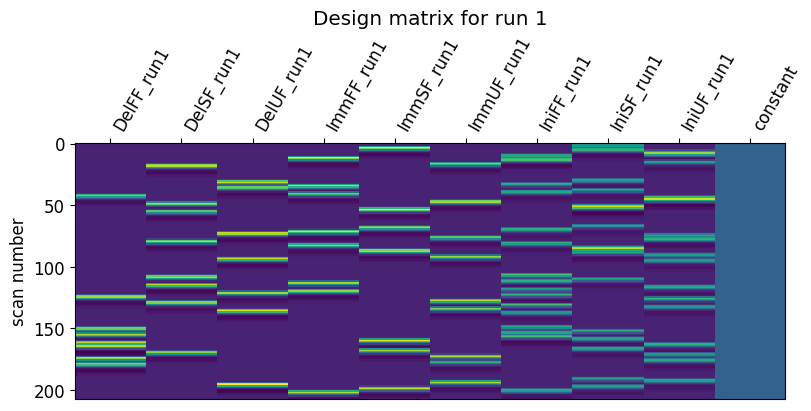

In [33]:
# reference slice
TR = layout.get_tr()
slice_timing = layout.get_metadata(bold[0])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR
  #print('Slice timing reference:', slice_time_ref)

for run in [1]:  # range(nruns)
    nvols = nib.load(bold[run]).shape[-1]
    frame_times = np.linspace(0, (nvols - 1) * TR, nvols) + slice_time_ref # adjust for slice-timing

    design_matrix = nil.glm.first_level.make_first_level_design_matrix(frame_times, 
                                                                       events = events[run], 
                                                                       hrf_model = 'spm', 
                                                                       drift_model = 'cosine', 
                                                                       high_pass = 0, 
                                                                       drift_order = None)
    plt.rcParams.update({'font.size': 12}); 
    nil.plotting.plot_design_matrix(design_matrix, output_file=None)
    fig = plt.gcf(); plt.title('Design matrix for run ' + str(run)); fig.set_size_inches(8,4); plt.show();


\
Now we'll load the movement parameters as covariates...

In [34]:
confound_files = layout.get(subject = sID, datatype = 'func', desc = 'confounds', extension = ".tsv", return_type = 'filename')
relevant_confounds = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
confounds_for_glm = []
for conf_file in confound_files:
    this_conf = pd.read_table(conf_file)
    conf_subset = this_conf[relevant_confounds].fillna(0) # replace NaN with 0
    confounds_for_glm.append( conf_subset )

\
...load an analysis mask (the whole brain)...


In [35]:
brain_mask_file = layout.get(return_type = 'file', datatype = 'func', suffix = 'mask', desc = 'brain', space = 'MNI152NLin6Asym', extension = 'nii.gz')[0] 
# this should be the same space as the preprocessed data
brain_mask = nib.load(brain_mask_file)

\
...and define the other settings for the model:

In [36]:
fmri_glm = nil.glm.first_level.FirstLevelModel(t_r = TR,
                                               slice_time_ref = slice_time_ref,
                                               hrf_model = 'spm',
                                               drift_model = 'cosine',
                                               drift_order = 1,
                                               high_pass = 0.01,
                                               smoothing_fwhm = None,
                                               signal_scaling = (0, 1), # grand mean scaling only
                                               noise_model = 'ols', # no need for 'ar1' if only care about Betas, should speed up
                                               mask_img = brain_mask,
                                               memory = 'scratch', memory_level=2);

\
Note that:
- we are not adding spatial smoothing, because we do not necessarily want to lose fine-scale information.
- we can use the quicker "ols" rather than "ar1" model of the error autocorrelation, because we do not need statistical tests, only the beta estimates.

Now we can estimate the model for all runs. This could take around a minute...

In [37]:
tic = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # nilearn would warn about us specifying a mask
    fmri_glm.fit(bold, events, confounds_for_glm); # this takes about 16-73 s ? 
print('Took ', time.time()-tic,' s')

Took  50.087549448013306  s


\
Next, we define which of the estimated beta patterns we want to classify, and to which classes they belong. 
Recall that we'll classify famous faces (FF) from scrambed faces (SF), while ignoring unfamiliar faces (UF). 
For each of these, we have three beta estimates: one for the initial presentation of each stimulus (Ini), one for immediate repeats (Imm) and one for delayed repeats (Del).
Thus we are interested in six of nine conditions, each of which belong to one of two classes:

In [38]:
# conditions_to_decode = ['DelFF', 'DelSF', 'DelUF', 'ImmFF', 'ImmSF', 'ImmUF', 'IniFF', 'IniSF', 'IniUF']
conditions_to_decode   = ['DelFF', 'DelSF',          'ImmFF', 'ImmSF',          'IniFF', 'IniSF'         ]  
print('\nConditions to decode:\n', conditions_to_decode)

class_labels = [x[3:] for x in conditions_to_decode]
print('\nClass labels:\n', class_labels)

labels_per_run = [ lab_enc.fit_transform(class_labels) for r in range(nruns) ]


Conditions to decode:
 ['DelFF', 'DelSF', 'ImmFF', 'ImmSF', 'IniFF', 'IniSF']

Class labels:
 ['FF', 'SF', 'FF', 'SF', 'FF', 'SF']


\
To extract the beta patterns for each condition of each run, we define "contrasts". Here, each contrast will be a vector of zeros for all conditions of all runs, except for a single 1 that targets a single condition of a single run: 

In [39]:
affine = nib.load(bold[0]).affine # needed for writing images below

tic = time.time()

betas_per_run_nii = []   # for list of nifti objects

for run in range(nruns): # for each run...

    Xcols=(fmri_glm.design_matrices_[run].columns) # regressor names for this run
       
    beta_maps  = [] # to store the betas for each condition of interest in this run
    
    print(f'Run {run}: Creating {len(conditions_to_decode)} beta volumes and storing them as a 4D array...')

    for condition in conditions_to_decode: # for each condition type that we want to classify...

        # initialise contrast vectors of zeros for all runs (nilearn would accept NaNs, but then set all outputs to NaN):
        contrast_list = [ np.zeros((1, len(fmri_glm.design_matrices_[r].columns))) for r in range(nruns) ]
       
        # set one-hot vector for this condition of this run:
        reg_name = condition + '_run' + str(run) # add the run suffix to get the regressor name
        contrast_list[run][0, Xcols.get_loc(reg_name)] = 1
   
        # compute the betas
        with warnings.catch_warnings():
            warnings.simplefilter("ignore") # nilearn would warn for every run with an all-zero vector 
            beta_map = fmri_glm.compute_contrast(contrast_list, output_type = 'effect_size'); # returned as a nifti object
        beta_maps.append( beta_map )

        # nil.plotting.plot_stat_map(beta_map, threshold=0, cmap='bwr', cut_coords=(-18, -31, -16));

    betas_per_run_nii.append( nil.image.concat_imgs(beta_maps) ) # Stack the maps along the 4th dimension, and add to per-run list
    
    # fname = os.path.join(beta_dir, os.path.basename(bold[run]).split("space")[0] + 'SixConditions_Betas.nii.gz'); # file name if we wanted to save it  
    # nib.save(betas_per_run_nii[run], fname);
nib.Nifti1Image
print('Took ', time.time()-tic,' s')

# Remove the cached directory
!rm -rf scratch/joblib/

Run 0: Creating 6 beta volumes and storing them as a 4D array...
Run 1: Creating 6 beta volumes and storing them as a 4D array...
Run 2: Creating 6 beta volumes and storing them as a 4D array...
Run 3: Creating 6 beta volumes and storing them as a 4D array...
Run 4: Creating 6 beta volumes and storing them as a 4D array...
Run 5: Creating 6 beta volumes and storing them as a 4D array...
Run 6: Creating 6 beta volumes and storing them as a 4D array...
Run 7: Creating 6 beta volumes and storing them as a 4D array...
Run 8: Creating 6 beta volumes and storing them as a 4D array...
Took  11.758388042449951  s


\
Let's just check the shape of the data array from one run:


In [40]:
print(f"Shape of betas for first run: {betas_per_run_nii[0].shape}")

Shape of betas for first run: (61, 73, 61, 6)


\
The first three dimensions are the x, y, and z coordinates. The 4th dimension is conditions. 

As intended, we have extracted beta patterns for six conditions for this run.

## ROI-based classification

We don't expect all of these voxels to contain signal (some are not even in the brain!). So we will **select voxels from a Region Of Interest (ROI)**. This is a type of **feature selection**, which restricts the analysis to brain regions we are interested in. 

### Define an ROI

To avoid biasing the results, any data used for feature selection must be independent of the data being classified. Since these data are in MNI space, we can use any mask independently defined in MNI space. Here, we'll use Nilearn to load anatomical ROIs from the Harvard-Oxford atlas. These are returned as a dictionary that stores the `filename`, `description` and, importantly, `labels` (ROI names) and `maps` (a 3D volume of integers that index the ROI names):

[fetch_atlas_harvard_oxford] Dataset found in /home/cognestic/COGNESTIC/09_MVPA_MRI/Decoding/fsl

File name of atlas: /home/cognestic/COGNESTIC/09_MVPA_MRI/Decoding/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz

ROI names:
 ['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus'

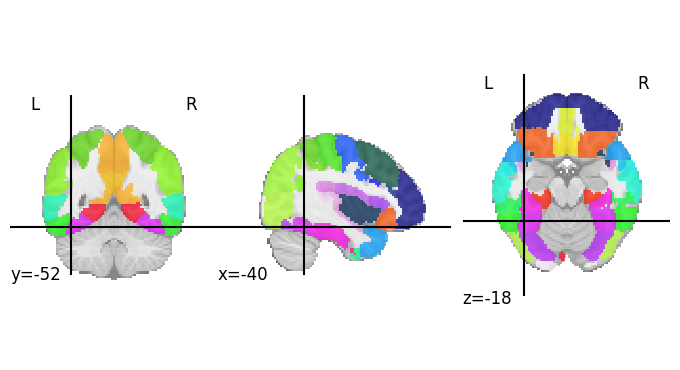


Shape of ROI map:
 (91, 109, 91)


In [41]:
HO_atlas = nil.datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', demo_dir) # this is a maximum-probability, anatomical atlas, thresholded at 25%, with 2 mm resolution
print("\nFile name of atlas:", HO_atlas['filename'])
# print(HO_atlas['description'])
print("\nROI names:\n", HO_atlas['labels'])
# print("ROI mask:\n", HO_atlas['maps'])
nil.plotting.plot_roi(HO_atlas['filename'], cut_coords = (-40, -52, -18), colorbar = False); # we'll put the cross-hairs near the left FFA
plt.show();
print("\nShape of ROI map:\n", HO_atlas['maps'].shape)

We can see that, although the functional data and the ROI masks are both in MNI space, they have different dimensions. We can use nilearn to **resample** the ROIs to match the data:

In [42]:
resampled_ROI_map = nil.image.resample_to_img(HO_atlas['maps'], betas_per_run_nii[0],
                                              interpolation = 'nearest',
                                              force_resample = True,
                                              copy_header = True)
# note that for continuous-valued data we would want continuous interpolation, but here nearest-neighboour interpolation preserves the integer ROI values 
print("Shape of resampled ROI map:", resampled_ROI_map.shape)

Shape of resampled ROI map: (61, 73, 61)


\
Now we'll select the bilateral "Temporal Occipital Fusiform Cortex" region, which is close to the fusiform face area (FFA) that is expected to have a face-selective response.

We'll use nilearn's `math_img` function to turn this region into a binary mask. It's sensible to plot this, to check that it looks correct:


Indices of fusiform ROI: 39


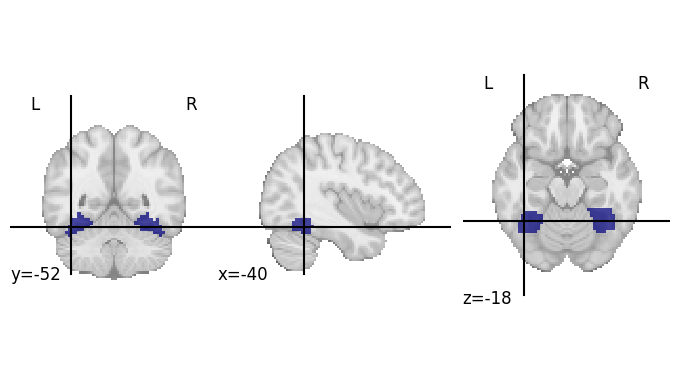

In [43]:
fusi_id = HO_atlas['labels'].index('Temporal Occipital Fusiform Cortex')
print("\nIndices of fusiform ROI:", fusi_id)

fusi_ROI = nil.image.math_img(f'(map == {fusi_id})', map = resampled_ROI_map)
nil.plotting.plot_roi(fusi_ROI, cut_coords=(-40, -52, -18), colorbar = False);

### Extract data from ROI

Now we can pass this ROI to a `masker` object, and apply it to the activation maps to extract the patterns we are interested in. 

We'll start by looking at the first run:

In [44]:
### You could instead use the ROI defined by the univariate contrast of faces versus scrambled faces, estimated in a previous session: 
# fusi_ROI = nib.load('/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition/results/FFA_sphere_and_faces-scrambled_fwe.nii.gz')
### (This should already be in the same space as the data, so it needn't be resampled.)
### However, this would NOT BE INDEPENDENT of the data we will classify, so the results would be biased.

fusi_masker = nil.maskers.NiftiMasker(fusi_ROI)

beta_patterns = fusi_masker.fit_transform(betas_per_run_nii[0]) # just look at the first run for now
# (if we hadn't resampled the ROI, the masker could also do this; we would provide "target_affine" as the space of the data)

print('Shape of pattern matrix from chosen ROI:', beta_patterns.shape)

Shape of pattern matrix from chosen ROI: (6, 431)


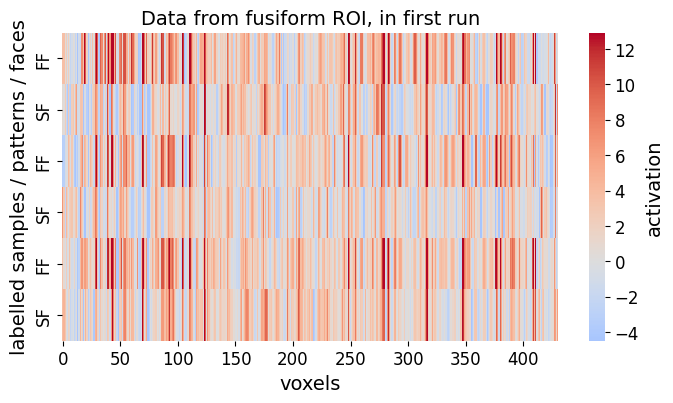

In [45]:

fig, ax = plt.subplots(figsize = (8, 4))
sns.heatmap(beta_patterns, cmap='coolwarm', center = 0, robust = 1, xticklabels = 50, yticklabels = class_labels)
ax.set_title('Data from fusiform ROI, in first run' , fontsize = 14)
ax.set_xlabel( "voxels" , fontsize = 14)
ax.set_ylabel("labelled samples / patterns / faces" , fontsize = 14)
ax.tick_params(axis='x', labelsize = 12)
ax.tick_params(axis='y', labelsize = 12)
ax.collections[0].colorbar.set_label("activation", fontsize = 14)

\
We can see that some of these voxels are correlated, and some will be noisier than others. Classifiers are often able to handle this, but we may choose to apply **dimension reduction**. This is sometimes called **feature extraction**, and a common method is principle component analysis (**PCA**):


Shape of pattern matrix after PCA: (6, 5)


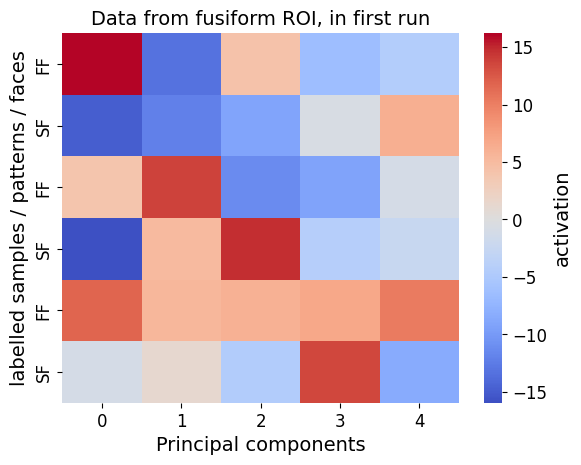

In [46]:
beta_patterns = scaler.fit_transform(beta_patterns)

PCA = skl.decomposition.PCA(n_components = 5) # the number of components should be smaller than the smallest dimension of the input
PCA.fit(beta_patterns)
beta_patterns_PCA5 = PCA.transform(beta_patterns)

print("\nShape of pattern matrix after PCA:", beta_patterns_PCA5.shape)

ax = sns.heatmap(beta_patterns_PCA5, cmap = 'coolwarm', center = 0, xticklabels = 1, yticklabels = class_labels)
ax.set_title('Data from fusiform ROI, in first run' , fontsize = 14)
ax.set_xlabel( "Principal components" , fontsize = 14)
ax.set_ylabel("labelled samples / patterns / faces" , fontsize = 14)
ax.tick_params(axis='x', labelsize = 12)
ax.tick_params(axis='y', labelsize = 12)
ax.collections[0].colorbar.set_label("activation", fontsize = 14)

Note that features are typically standardized before PCA, otherwise the principal components will be dominated by features with larger scales. However, standardization means that features that originally had low variance will be upweighted, under the assumption that all features are expected to be equally predictive. In fMRI, noisy/non-predictive features may have low variance, so upweighting them may be detrimental to performance.

Also, pattern variance might be dominated by aspects of the stimulus or mental state other than the distinction we are tying to classify. In that case, PCA might discard higher-numbered components that could have been informative. Thus, similar to spatial smoothing, PCA can either help or hinder, depending on the relative suppression/enhancement of signal versus noise.

### Classify using leave-one-run-out cross-validation

Now, let's put everything together: 
Load ROI data from all runs...

In [47]:
# (If you wanted to remove the mean across voxels for each condition, you could use the "demeaner" transform below.
# However, typically the mean signal will carry useful information that helps to distinguish the classes.)
# demeaner = skl.preprocessing.StandardScaler(with_mean=True, with_std=False)

ROI_patterns_per_run = [] # list of ROI's pattern matrices (one for each run)
for run in range(nruns):
    print('Extracting ROI pattern from run ',run)
    ROI_patterns = fusi_masker.fit_transform(betas_per_run_nii[run])
    # ROI_patterns = demeaner.fit_transform(ROI_patterns.transpose()).transpose() # remove mean across voxels
    ROI_patterns_per_run.append( ROI_patterns ) 
    

Extracting ROI pattern from run  0
Extracting ROI pattern from run  1
Extracting ROI pattern from run  2
Extracting ROI pattern from run  3
Extracting ROI pattern from run  4
Extracting ROI pattern from run  5
Extracting ROI pattern from run  6
Extracting ROI pattern from run  7
Extracting ROI pattern from run  8


\
...concatenate the data, labels, and run indices, across runs...

In [48]:
all_data    = np.concatenate(ROI_patterns_per_run, axis = 0) # concatenate data across runs
all_labels  = np.concatenate(labels_per_run,       axis = 0) # concatenate labels across runs
run_indices = np.concatenate([[i] * np.size(ROI_patterns_per_run[i], axis = 0) for i in range(nruns)]) # label each run number
print('Run indices: ', run_indices)

print(f"Total of {all_data.shape[0]} patterns")

Run indices:  [0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 5 5 5 5 5 6
 6 6 6 6 6 7 7 7 7 7 7 8 8 8 8 8 8]
Total of 54 patterns


\
...and try to decode faces within this ROI, using leave-one-run-out cross-validatation.
This time we'll use yet another classifier - a **Fisher's linear discriminant (LDA)** classifer:

In [49]:
LDA  = skl.discriminant_analysis.LinearDiscriminantAnalysis();
pipe = pipeline.make_pipeline(PCA, LDA)

fold_score = skl.model_selection.cross_val_score(pipe, all_data, all_labels, groups = run_indices,
                                    scoring = 'roc_auc', cv = logo)
observed_score = np.mean(fold_score)
print("Cross-validated score per fold:", fold_score)  
print("Mean cross-validated score:  ", observed_score)

Cross-validated score per fold: [1.    0.889 0.889 1.    1.    1.    1.    1.    1.   ]
Mean cross-validated score:   0.9753086419753088


### Test significance

This looks very accurate! But we should still confirm that it is *significantly* above chance (See Rik's session on statistics.) 

We cannot test this using a t-test across folds, because the folds are not independent (they share training data). 

If we had multiple participants, we could use a **one-sample t-test across participants**, versus chance. This is valid (assuming the specified chance level is correct) because participants are independent. 

For "within-context" cross-validation, below-chance accuracy is not meaningful (the true value can't be negative), which means we can use a one-tailed test; it also means that the test only provides fixed-effects rather than random-effects inference (see [Allefeld et al., 2016](https://pubmed.ncbi.nlm.nih.gov/27450073/)). For cross-validation that generalises *across* contexts (e.g. train the classifer to decode famous versus scrambled faces on initial presentations, then test decoding on repeated presentation) negative performance *could* be meaningful, so random-effects inference is justified, and a two-tailed test is appropriate. Similarly, when comparing classfication performance across conditions (e.g. is the performance of face decoding at initial presentation different from at repeat presentation?), paired-tests or repeated-measures ANOVA allow random-effects inference.

However, if we want **to assess significance for a single participant, we would need a permutation test**. (Actually this applies to testing the significance of any single *classification* that can't be repeated across independent samples, e.g. a single classification of the disease status of multiple participants.) The permutation test involves shuffling the labels many times (e.g. 10,000) to generate a null distribution of classifier performance that would be expected under the null hypothesis of no difference between classes.

In some situations, permutation tests may be necessary, but they do have disadvantages:
 - the large number of required permutations makes them slow
 - low numbers of samples limit the number of unique permutations, which limits robustness of the p-value
 - there's some complexity in ensuring the labels are actually "exchangeable", and hence risk of error.

First, we'll code the permutations explicitly. It is important that this is done outside the cross-validation loop ([Valente et al., 2021](https://www.sciencedirect.com/science/article/pii/S1053811921004225#bib0022)):

In [ ]:
folds = tuple(logo.split(all_data, all_labels, run_indices))

n_permutations = 200 # this is not nearly enough, but it will still take a while
permuted_scores = np.zeros(n_permutations)
null_labels = np.concatenate(labels_per_run, axis = 0) # re-concatenate labels across runs; to be shuffled below

print(f'Permuting {n_permutations} times:')
tic = time.time()
for p in range(n_permutations):

    okay = False

    while not okay:
        np.random.shuffle(null_labels) # (shuffle operates in-place)

        try:
            fold_score=np.full(nruns,np.nan)
            for i, fold in enumerate(folds):
                train_idx, test_idx = fold   

                pipe.fit(all_data[train_idx,:], null_labels[train_idx])
                predicted_probabilities = pipe.predict_proba(all_data[test_idx,:]) # do prediction on test data
                fold_score[i] = skl.metrics.roc_auc_score(null_labels[test_idx], predicted_probabilities[:,1]) # syntax for binary classifcation
            okay = True
        except:
            okay = False
            
    permuted_scores[p] = np.mean(fold_score)
    print('.', end='')
print('Done.')
print('Took ', time.time()-tic,'  s')

\
Now let's plot the observed score and compare it to the null distribution of scores from permuted data:

In [ ]:
ax = sns.histplot(permuted_scores, element = 'step', alpha = 0.5)
ax.set(xlabel = 'AUROC of permuted data');
lh = ax.axvline(np.percentile(permuted_scores, 95), color = 'b',label = '95% threshold')
mh = ax.plot(observed_score, 0, marker = 'o', color = 'r', markersize = 10, label = 'observed score')
ax.legend();

p = (sum(permuted_scores > observed_score) + 1) / (n_permutations + 1)
print('p vlaue = ', p)

As expected, the null distribution is centred around chance (0.5). The observed score is more extreme than the 95th percentile, so the classification is significantly above chance.

\
Just as scikit-learn has a function (`cross_val_score`) to simplify the cross-validation loop, it also has a similar function (`permutation_test_score`) to simplify the permutation process. This also allows the permutation to be run in parallel, which can be much faster! 

In [ ]:
n_permutations = 1000 # this is more like it

tic = time.time()
actual_score, permuted_scores, p = skl.model_selection.permutation_test_score(pipe, all_data, all_labels, groups = run_indices,
                                    scoring = 'roc_auc', cv = logo, n_permutations = n_permutations, n_jobs = -1, random_state = None)

print('Took ', time.time()-tic, ' s')
print("p value = ", p)

\
This p-value should, on average, be similar to above, but will differ because of the randomness of the permutations. As the number of unique permutations increases, the p-values from different repetitions should become more similar, giving an idea of the robustness of the permutation-p-value.

## Searchlight analysis

So far, we have considered a single ROI. If we want to know where in the brain a representation is strongest, we can compare multiple ROIs. Sometimes, we might be interested in discrete regions that cover the brain (e.g. an atlas/parcellation), but if we want a spatially continuous output, without making assumptions about area borders, we can use a "searchlight". 

A searchlight is just a set of overlapping ROIs, often spherical, that cover the brain (or analysis mask of interest). Each searchlight's classification performance is typically assigned to its central voxel. The inferences one would make are very similar to a voxel-wise, mass-univariate analysis of smoothed data (see Dace's sessions). Increasing the size of the searchlight reduces the spatial specificity of the inference, while tending to increase sensitivity, in a very similar way to increasing the smoothing kernel in univariate analysis. Similarly to the matched-filter theorem for univariate analyses, the optimal searchlight size will depend on the spatial scale of the signal and the spatial scale of the noise. It is sometimes assumed that searchlights need to be spatially contiguous, because they usually are, but the definition of a searchlight is just as flexible as the definition of any ROI. 

### Define the search space

A searchlight analysis can be set up using nilearn's `.searchlight` object. This *is* restricted to contiguous spherical searchlights. When the searchlight object is created, it needs a "voxel" mask that specifies which voxels will be included in the searchlights.

We'll use a voxel mask that covers the whole brain. As before, we can load a template-space mask from nilearn, and resample it to match the data: 

In [ ]:
brain_mask = nil.datasets.load_mni152_brain_mask()
brain_mask = nil.image.resample_to_img(brain_mask, betas_per_run_nii[0], 
                                       interpolation = 'nearest',
                                       force_resample = True,
                                       copy_header = True)

# we'll also restrict this mask to voxels that have data
has_data =   nil.image.math_img('(img.prod(axis=3) !=0)', img = betas_per_run_nii[0]); # not zero for any sample
brain_mask = nil.image.math_img('(in_mask & has_data)', in_mask = brain_mask, has_data = has_data);

display = nil.plotting.plot_roi(brain_mask,
                                alpha=0.5,
                                cmap='summer', 
                                cut_coords=(-40, -52, -18),
                                colorbar=False);

We can also provide a second, optional, "process mask" that constrains where the spheres are centred. To save some time, we'll restrict this to cortical grey matter of the left hemisphere:

In [ ]:
HO_atlas_subcort = nil.datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm', demo_dir) 
resampled_atlas  = nil.image.resample_to_img(HO_atlas_subcort['maps'], betas_per_run_nii[0],
                                              interpolation = 'nearest',
                                              force_resample = True,
                                              copy_header = True)
l_cortex_id = HO_atlas_subcort['labels'].index('Left Cerebral Cortex')  # get the ID of the Left Cerebral Cortex

gm_mask = nil.image.math_img(f'(map == {l_cortex_id} )', map = resampled_atlas)               # create binary mask of this ROI
gm_mask = nil.image.math_img('(in_mask & has_data)', in_mask = gm_mask, has_data = has_data); # restrict mask to voxels that have data

display = nil.plotting.plot_roi(nil.image.math_img('a+b', a = gm_mask, b = brain_mask),
                                alpha=0.5,
                                cmap='summer', 
                                cut_coords=(-40, -52, -18),
                                colorbar=False);

In the image above, green voxels could be part of each spherical searchlight (depending on its radius), but the centre of the spheres will only ever be placed in the yellow voxels.

### Run the searchlight

Now we can create the `searchlight` object. We will also specify some other optional inputs, explained in the code below:

In [ ]:
pipe = skl.pipeline.make_pipeline(LDA) # we won't do PCA, because this would fail for some searchlights (think about why)

sl = nil.decoding.SearchLight(
    mask_img = brain_mask,       # only include these voxels within searchlights
    process_mask_img = gm_mask,  # only centre searchlights on these voxels 
    radius = 5,                  # in mm
    estimator = pipe,            # a classifier or pipeline object
    n_jobs = -1,                 # how many CPUs to use (-1 means the maximum available)
    scoring = 'roc_auc',         # choice of scoring metric
    cv = logo,                   # cross-validation object
    verbose = False              # this is slow, so if running locally (1 job) set it to true to know how far it's got; when running in parallel it produces too much output, so set to false
)

\
To launch the searchlight analysis, call the `searchlight` object's `.fit` method, passing it the patterns, the labels, and the groups for cross-validation.
This will take a while (probably about 4 minutes on the virtual machine, running in parallel with 4 cores)...

In [ ]:
all_data = nil.image.concat_imgs(betas_per_run_nii) # concatenate 4D nifti objects from each run (along the 4th dimension)

print('Shape of 4D nifti data:', all_data.shape)
print('Shape of mask:', sl.mask_img.shape)
print('Shape of process_mask:', sl.process_mask_img.shape)

print('Running searchlight...')
tic = time.time()
sl.fit(all_data, all_labels, groups = run_indices) # expect this to take ~ 3-5 minutes
print('Took ', time.time()-tic, ' s')

\
The output (here, mean AUROC) per voxel is stored in the  `scores_` property of the searchlight object (as a 3D numpy array). If we convert this to a nifti volume, we can plot it using nilearn. We'll also subtract chance (here, 0.5), so that positive and negative values will indicate above- and below-chance decoding performance:

In [ ]:
print('Shape of output numpy array: ', sl.scores_.shape)
scores_minus_chance = sl.scores_ - 0.5 # subtract chance
score_img = nil.image.new_img_like( brain_mask, scores_minus_chance); # save in samme format as the brain_mask
score_img = nil.image.math_img('score_img * processing_mask', score_img = score_img, processing_mask = gm_mask); # set voxels outside the processing mask to zero
nil.plotting.plot_stat_map(score_img, threshold = 0, cmap = 'bwr', cut_coords = (-40, -52, -18));

You can see reasonable classification in the fusiform gyrus, as expected.

In [ ]:
nil.plotting.view_img_on_surf(score_img, threshold = 0, cmap = 'bwr', symmetric_cmap = True, darkness = None)

This is the end of this MVPA demo.